In [1]:
import numpy as np
import astropy.units as u
import time
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))
import poppy
import skimage
from skimage.registration import phase_cross_correlation
import copy
from importlib import reload

import magpyx
from magpyx.utils import ImageStream
import purepyindi
from purepyindi import INDIClient
client0 = purepyindi.INDIClient('localhost', 7624)
client0.start()

import purepyindi2
from purepyindi2 import IndiClient
client = IndiClient()
client.connect()
client.get_properties()

from math_module import xp, xcipy, np_array
import utils
import fsm_utils
import cam_utils
from imshows import imshow1, imshow2, imshow3
from matplotlib.patches import Circle

v_bias = np.array([[50,50,50]]).T

wavelength = 633e-9
fl = 500e-3
fsm_pupil_diam = 6.8e-3
as_per_lamD = (wavelength/fsm_pupil_diam*u.radian).to(u.arcsec)
print(as_per_lamD)

pxscl_lamD = 3.45e-6 / (fl * wavelength/fsm_pupil_diam)
print(pxscl_lamD)


/opt/conda/envs/km310gpu/lib/python3.10/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')
INFO:purepyindi2.transports:Connected to localhost:7624


19.200826816825295 arcsec
0.07412322274881515


In [8]:
fsm = ImageStream('fsm')
fsm.write(v_bias)

In [4]:
amp = 1*as_per_lamD

freq = 1*u.Hz
t_max = (1/freq).to(u.s)
Nsamps = 19
times = np.linspace(0, t_max, Nsamps)
delt = (times[1]-times[0]).to_value(u.s)

wave = amp*np.sin(2*np.pi*freq.to_value(u.Hz)*times.to_value(u.s))/np.sqrt(2)
volt_commands = np.zeros((Nsamps, 3, 1))
for i in range(Nsamps):
    volt_commands[i] = fsm_utils.get_fsm_volts(tip=wave[i], tilt=0*u.arcsec)

Displacements: A = 5.00e-06 m, 5.00e-06 m, 5.00e-06 m. 
Delta Voltages: A = 50.00, B = 50.00, C = 50.00. 
Displacements: A = 5.16e-06 m, 4.92e-06 m, 4.92e-06 m. 
Delta Voltages: A = 51.56, B = 49.22, C = 49.22. 
Displacements: A = 5.29e-06 m, 4.85e-06 m, 4.85e-06 m. 
Delta Voltages: A = 52.93, B = 48.53, C = 48.53. 
Displacements: A = 5.39e-06 m, 4.80e-06 m, 4.80e-06 m. 
Delta Voltages: A = 53.95, B = 48.03, C = 48.03. 
Displacements: A = 5.45e-06 m, 4.78e-06 m, 4.78e-06 m. 
Delta Voltages: A = 54.49, B = 47.75, C = 47.75. 
Displacements: A = 5.45e-06 m, 4.78e-06 m, 4.78e-06 m. 
Delta Voltages: A = 54.49, B = 47.75, C = 47.75. 
Displacements: A = 5.39e-06 m, 4.80e-06 m, 4.80e-06 m. 
Delta Voltages: A = 53.95, B = 48.03, C = 48.03. 
Displacements: A = 5.29e-06 m, 4.85e-06 m, 4.85e-06 m. 
Delta Voltages: A = 52.93, B = 48.53, C = 48.53. 
Displacements: A = 5.16e-06 m, 4.92e-06 m, 4.92e-06 m. 
Delta Voltages: A = 51.56, B = 49.22, C = 49.22. 
Displacements: A = 5.00e-06 m, 5.00e-06 m, 5.0

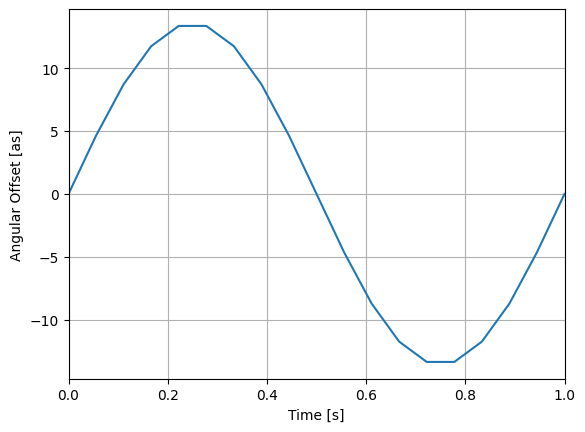

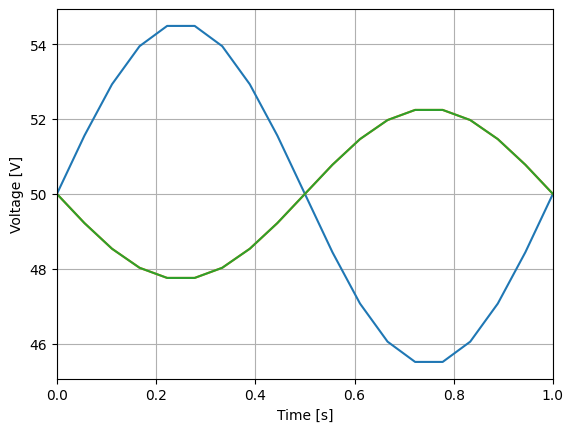

In [5]:
import matplotlib.pyplot as plt
plt.plot(times, wave)
plt.xlim([0, t_max.to_value(u.s)])
plt.xlabel('Time [s]')
plt.ylabel('Angular Offset [as]')
plt.grid()
plt.show()

plt.plot(times, volt_commands[:,0])
plt.plot(times, volt_commands[:,1])
plt.plot(times, volt_commands[:,2])
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.xlim([0, t_max.to_value(u.s)])
plt.grid()
plt.show()

In [7]:
freq = 5 * Nsamps
try:
    print('Modulating FSM ...')
    i = 0
    while i<Nsamps+1:
        if i==Nsamps:
            i = 0
        fsm.write(volt_commands[i])
        time.sleep(1/freq)
        i += 1
except KeyboardInterrupt:
    print('FSM modulation stopped!')
    fsm.write(v_bias)

Modulating FSM ...
FSM modulation stopped!


In [ ]:
v_tt = fsm_utils.get_fsm_volts(tip=0*as_per_lamD, tilt=2*as_per_lamD)
volts = [v_bias, v_tt]
freq = 2
try:
    print('Modulating FSM ...')
    i = 0
    while True:
        fsm.write(volts[i%2])
        i += 1 
        time.sleep(1/freq)
except KeyboardInterrupt:
    print('FSM modulation stopped!')
    fsm.write(v_bias)

In [32]:
set_fsm_mod_amp(1, client0)
set_fsm_mod_rate(1, client0)


In [33]:
start_fsm_mod(client0)

In [34]:
stop_fsm_mod(client0)

In [35]:
fsm.write(0*v_bias)

In [27]:
fsm.buffer

array([[50.],
       [50.],
       [50.]], dtype=float32)

In [18]:
v_tt = fsm_utils.get_fsm_volts(tip=0*as_per_lamD, tilt=0.2*as_per_lamD)
volts = [v_bias, v_tt]
freq = 7
try:
    print('Modulating FSM ...')
    i = 0
    while True:
        fsm.write(volts[i%2])
        i += 1 
        time.sleep(1/freq/2)
except KeyboardInterrupt:
    print('FSM modulation stopped!')
    fsm.write(v_bias)


Displacements: A = 5.00e-06 m, 5.11e-06 m, 4.89e-06 m. 
Delta Voltages: A = 50.00, B = 51.12, C = 48.88. 
Modulating FSM ...
FSM modulation stopped!


In [43]:
fsm.write(0*v_bias)